In [34]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os
from sklearn.model_selection import train_test_split
import glob
from custom_defs import explore,view_shapes
import tqdm
import pandas as pd

## Selected Classes 
Only .jpg

In [12]:
targets=["maggie_simpson",
         "ned_flanders",
         "moe_szyslak",
         "krusty_the_clown",
         "principal_skinner",
         "charles_montgomery_burns",
         "gary_chalmers",
         "milhouse_van_houten",
         "chief_wiggum",
         "abraham_grampa_simpson"]
classes=dict()

In [17]:
for ind,value in enumerate(targets):
    paths=glob.glob("C:/Users/migue/OneDrive/Escritorio/Tercer_Semestre/DATASETS/Springfield/**/{}/".format(value),recursive=True)
    Total_Files=[]
    for i in paths:
        files=glob.glob("{}*.jpg".format(i))
        Total_Files+=files
    print("{}:{} files".format(value,len(Total_Files)))
    classes[value]={'path':paths,'all_img_paths':Total_Files,'label':ind}


maggie_simpson:1531 files
ned_flanders:1503 files
moe_szyslak:1502 files
krusty_the_clown:1256 files
principal_skinner:1245 files
charles_montgomery_burns:1241 files
gary_chalmers:1167 files
milhouse_van_houten:1140 files
chief_wiggum:1036 files
abraham_grampa_simpson:960 files


In [25]:
classes['maggie_simpson']['all_img_paths'][0]

'C:/Users/migue/OneDrive/Escritorio/Tercer_Semestre/DATASETS/Springfield\\simpsons_dataset\\maggie_simpson\\22pic_0000.jpg'

In [35]:
row_table=[]
for key,value in classes.items():
    train_val,test=train_test_split(value['all_img_paths'],
                                    test_size=0.1,
                                    random_state=1998)
    train,val=train_test_split(train_val,
                                train_size=0.80,
                                random_state=2022)
    classes[key]['train']=train
    classes[key]['validation']=val
    classes[key]['test']=test

    row_table.append({'Name':key,
                        'Train Image':len(train),
                        'Validation Image':len(val),
                        'Test Image':len(test)})
df=pd.DataFrame(row_table)[['Name',
                            'Train Image',
                            'Validation Image',
                            'Test Image']].sort_values('Train Image',ascending=False).reset_index(drop=True)

df.loc["Total"] = df.sum(numeric_only=True, axis=0)
df.fillna('')

,Nombre,Train Image,Validation Image,Test Image
0,maggie_simpson,1101.0,276.0,154.0
1,ned_flanders,1081.0,271.0,151.0
2,moe_szyslak,1080.0,271.0,151.0
3,krusty_the_clown,904.0,226.0,126.0
4,principal_skinner,896.0,224.0,125.0
5,charles_montgomery_burns,892.0,224.0,125.0
6,gary_chalmers,840.0,210.0,117.0
7,milhouse_van_houten,820.0,206.0,114.0
8,chief_wiggum,745.0,187.0,104.0
9,abraham_grampa_simpson,691.0,173.0,96.0


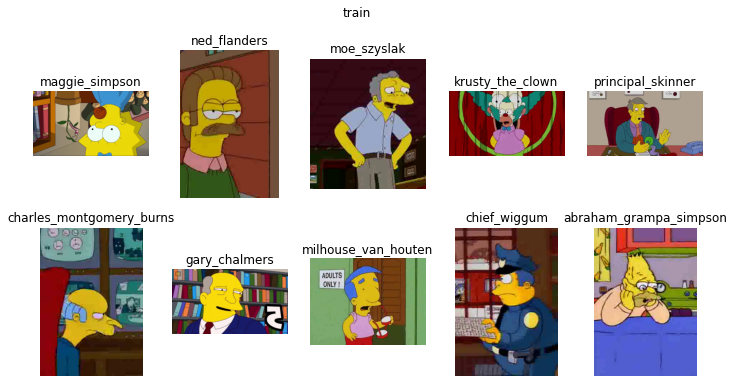

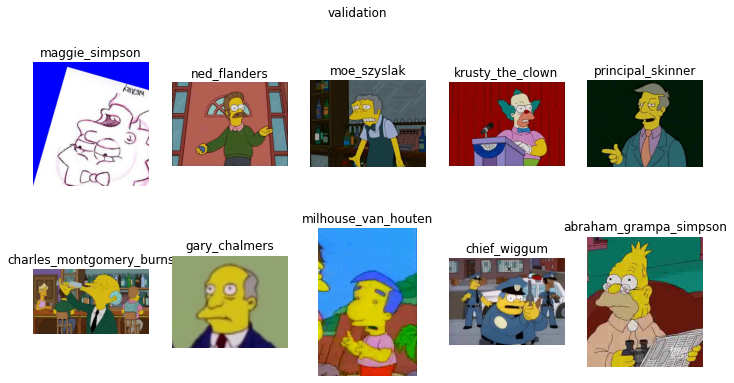

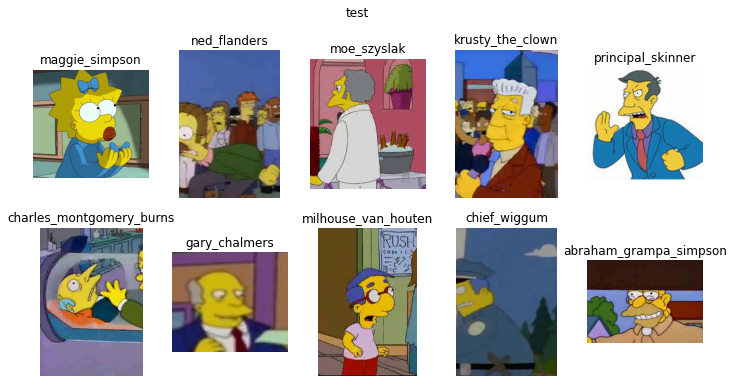

In [43]:
for set_name in ['train','validation','test']:
    i = 1
    plt.figure(figsize=(12, 6))
    plt.suptitle(set_name)
    for key, value in classes.items():
        img = io.imread(value[set_name][0])
        plt.subplot(2, 5, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(key)

        i += 1

## Guardar la configuración del Dataset

In [45]:
np.savez('SET_DATASET',**classes)
Configuracion=np.load('SET_DATASET.npz',allow_pickle=True)
Configuracion.files

In [70]:
Configuracion['maggie_simpson'].item().keys()

dict_keys(['path', 'all_img_paths', 'label', 'train', 'validation', 'test'])

## Preprocessing 